Data center dominates for artificial intelligence, cloud infrastructure, to cloud storage, computing and services become a norm for business. In environmental research, cloud service also raises to bridge and faciliate the exchange of knowledge. OpenGeoHub Foundation dedicates to freedom of knowledge and data of our planet earth. OpenLandMap GEDI is one of it. This dataset reconstructs, filters, and merges the raw orbit-oriented [Global Ecosystem Dynamics Investigation (GEDI)](https://gedi.umd.edu/) Level 2 A and B to a spatio-temporal blocking database and store in cloud-native vector format, [(Geo)Parquet](https://geoparquet.org/).

In this article, or you can call tutorial, we will dive in to the efficient way to access the dataset through code blocks. I hope after reading this, you will be able to not only access this dataset efficiently but also construct optimal code in any other programming languages to access other GeoParquet dataset.


First of all, let's look into what is OpenLandMap GEDI. You can visit OLM-GEDI STAC catalog to get detail information and visualize the database structure.

In the landing page, you are able to find an file called "GeoJSON STAC items" that summarizes this collection (Asset > GeoJSON STAC items > Download/Copy URL). So far, it is my favorite entry to access this dataset.

Here we copy the URL and open in a jupyternotebook Python environment.

The tutorial will use OpenLandMap GEDI Level2 data as example. This data is created by improving GEDI level2 from orbit-oriented data structure to spatio-temporal

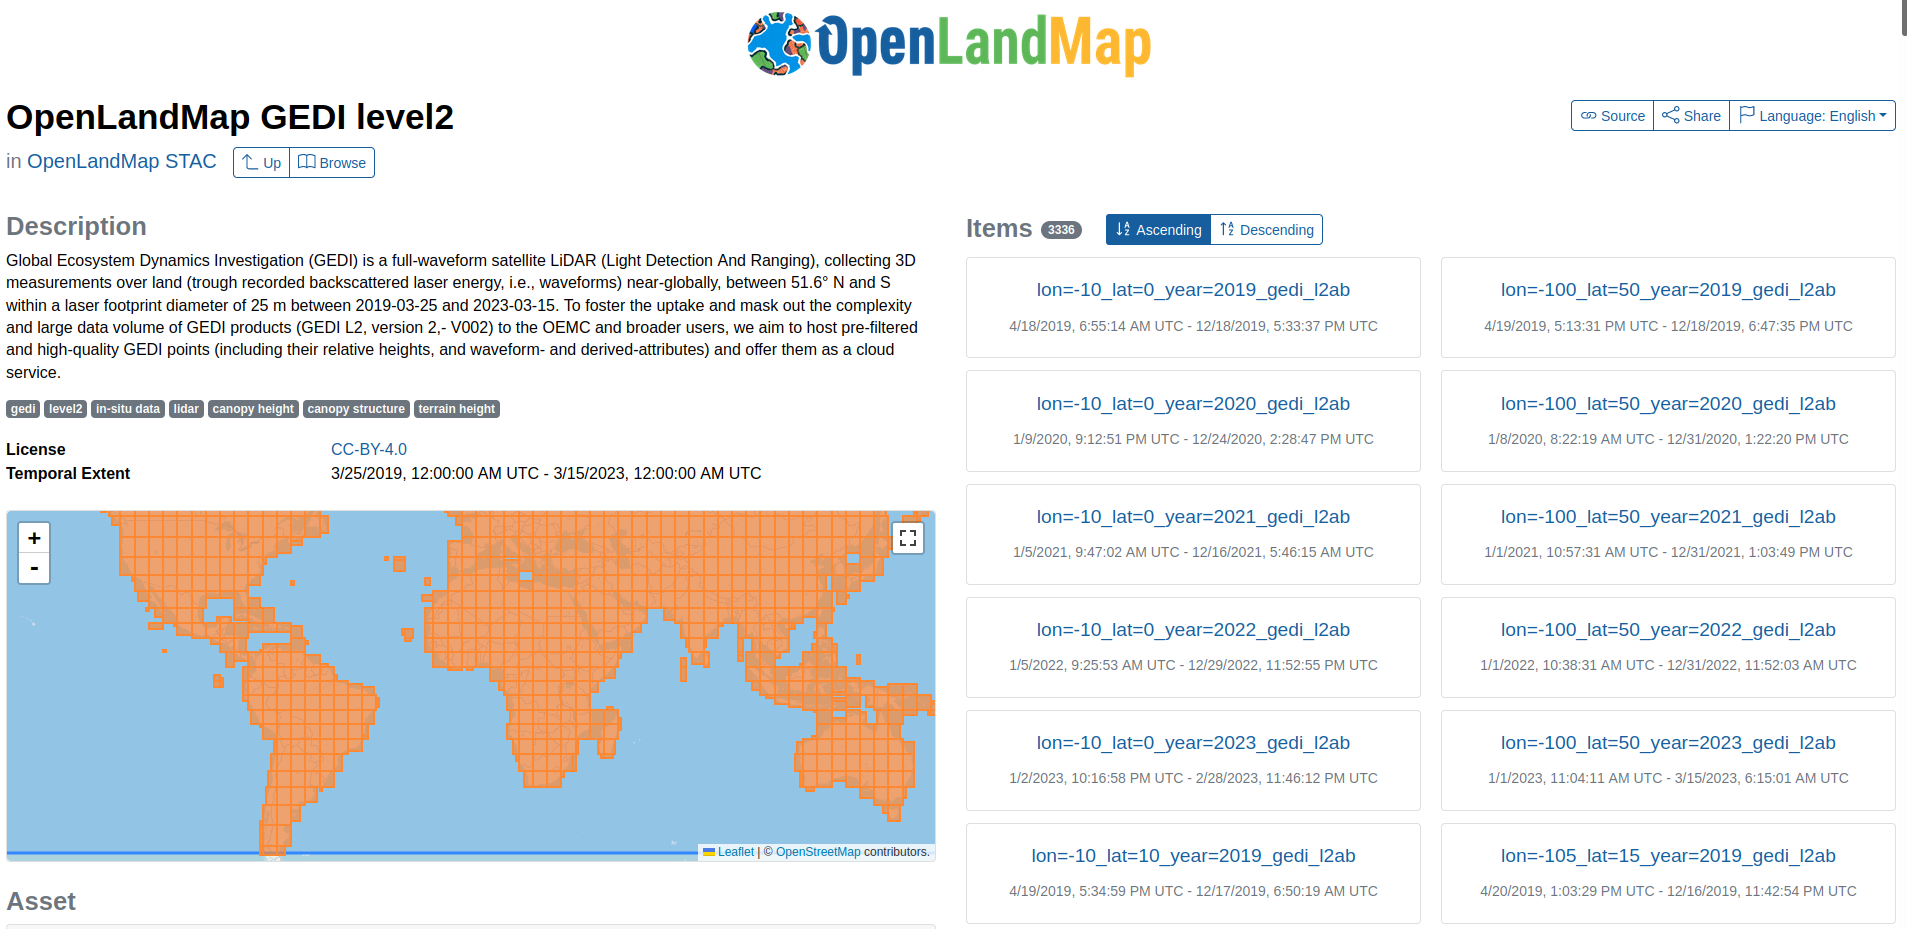

In [2]:
import geopandas as gpd
gedi_items=gpd.read_file('https://s3.eu-central-1.wasabisys.com/stac/openlandmap/GEDI02/stac_items_geojson')
print(gedi_items.columns)

Index(['item_id', 'size_in_mb', 'point_counts', 'year', 'start_date',
       'end_date', 'platform', 'stac_extentsion', 'asset_file', 'geometry'],
      dtype='object')


Here we can see
1. `item_id`: primary key for each STAC item
2. `size_in_mb`: the file size in Megabyte of each spatio-temporal block OLM-GEDI.
3. `point_counts`: the number of points in each file
4. `year`: the common year of all records in this file
5. `start_date`: the first record time in this file
6. `end_date`: the last record time in this file
7. `platform`: the GitHub respository of this dataset.
8. `stac_extension`: the URL to the GitHub respository of this dataset.
9. `asset_file`: the URL to this file of data record.
10. `geometry`: the bounding box of the file; the tile that all the records are within.

We now can try to visualize this collection using a folium map.

In [3]:
import folium
# Center the map on the world
m = folium.Map(location=[20, 0], zoom_start=2)

# Add GeoDataFrame to map with interactive style
folium.GeoJson(
    gedi_items[['item_id', 'size_in_mb', 'point_counts', 'geometry']],
    name="size_in_mb",
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.3,
    },
    tooltip=folium.GeoJsonTooltip(fields=["size_in_mb", "point_counts"])
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)
m

In [4]:
gedi_items.size_in_mb.sum()/1000

np.float64(777.548392630577)

You can browse a bit of the folium map. The tile is constructed in a spatio block as 5 x 5 degree, where some 5 degree tiles have smaller blocks due to its data availability. On the other hand, the temporal block is annual base.

In addition, you can run this:

In [5]:
print(gedi_items.size_in_mb.sum()/1000, 'GB')

777.548392630577 GB


where it tells you how big is this dataset (~777 GB) in total. Just to add some taste, It is equivalent to ~1.5 TB in other current vector format such as shapefile, geopackage, and flatgeobuf

To read about the performance comparision you can read this tech doc: https://cloudnativegeo.org/blog/2023/08/performance-explorations-of-geoparquet-and-duckdb/

However, most of the case, we do not need the whole world or the whole time period, or all the records that might not be relevant. In the traditional dataset setting, we need to download the whole dataset and filter offline.

Here is not the case, we are going to directly interact with the cloud infrastructure and retrieve the only relevant data entries for your interest.

As an example, we are going to navigate to the Netherlands for deomonstration. In this case, we hereby download the [GADM](https://gadm.org/) data for the country boundary

In [6]:
! wget https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_NLD_1.json.zip
! unzip gadm41_NLD_1.json.zip

--2025-08-29 14:07:34--  https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_NLD_1.json.zip
Resolving geodata.ucdavis.edu (geodata.ucdavis.edu)... 128.120.146.30
Connecting to geodata.ucdavis.edu (geodata.ucdavis.edu)|128.120.146.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29252 (29K) [application/zip]
Saving to: ‘gadm41_NLD_1.json.zip’

gadm41_NLD_1.json.z 100%[===================>]  28.57K  --.-KB/s    in 0.02s   

2025-08-29 14:07:34 (1.12 MB/s) - ‘gadm41_NLD_1.json.zip’ saved [29252/29252]

Archive:  gadm41_NLD_1.json.zip
  inflating: gadm41_NLD_1.json       


In [7]:
nl_level_1 = 'gadm41_NLD_1.json'
nl_provinces = gpd.read_file(nl_level_1)
print('crs of nl provinces -',nl_provinces.crs)
nl_provinces.head()

crs of nl provinces - EPSG:4326


,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,NLD.1_1,NLD,Netherlands,Drenthe,NA,NA,Provincie,Province,NA,NL.DR,NL-DR,"MULTIPOLYGON (((6.5237 52.6455, 6.5274 52.6148..."
1,NLD.2_1,NLD,Netherlands,Flevoland,NA,NA,Provincie,Province,NA,NL.FL,NL-FL,"MULTIPOLYGON (((5.3039 52.3125, 5.245 52.3294,..."
2,NLD.3_1,NLD,Netherlands,Fryslân,Friesland,NA,Provincie,Province,NA,NL.FR,NL-FR,"MULTIPOLYGON (((6.2392 52.9132, 6.2149 52.8909..."
3,NLD.4_1,NLD,Netherlands,Gelderland,Geldern|Gheldria|Guelders|Gueldr,NA,Provincie,Province,NA,NL.GE,NL-GE,"MULTIPOLYGON (((5.1358 51.7385, 5.1314 51.7394..."
4,NLD.5_1,NLD,Netherlands,Groningen,Groninga|Groningue,NA,Provincie,Province,NA,NL.GR,NL-GR,"MULTIPOLYGON (((6.9171 53.0116, 6.7468 53.1189..."


In [8]:
# Center the map to the Netherlands
m = folium.Map(location=[52,5], zoom_start=7)

# Add Dutch borders to map with interactive style
folium.GeoJson(
    nl_provinces,
    style_function=lambda x: {
        "color": "red",
        "weight": 1,
        "fillOpacity": 0.3,
    },
    tooltip=folium.GeoJsonTooltip(fields=["NAME_1"])
).add_to(m)

# Add STAC itmes to map with interactive style
folium.GeoJson(
    gedi_items[['item_id', 'size_in_mb', 'point_counts', 'geometry']],
    name="size_in_mb",
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.3,
    },
    tooltip=folium.GeoJsonTooltip(fields=["size_in_mb", "point_counts"])
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

m

Til now, we can narrow down the GEDI records to the closer area of Dutch borders by Geopandas spatial operation functions. In this example, we are not interested in looking into dutch province, so we also merge the province border into a single geometry as the Netherlands border.

In [9]:
from shapely.geometry import box
## Narrow down GEDI data
# 1. Get the total bounding box of Dutch borders
minx, miny, maxx, maxy = nl_provinces.total_bounds
bbox = box(minx, miny, maxx, maxy)

# 2. Filter GEDI STAC items  by intersection with bbox
gedi_nl = gedi_items[gedi_items.intersects(bbox)]

## Aggregate Province geometries to a single country geometry.
# 1. Merge all geometries in dataset2 into one
nl_poly = nl_provinces.dissolve()  # by default dissolves all into one multipolygon

# 2. Retrieve only the geometry (not GeoDataFrame):
nl_poly_union = nl_poly.unary_union

/tmp/ipython-input-100263740.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nl_poly_union = nl_poly.unary_union


Firstly, we use a single url (cloud-storage OLM-GEDI file), to focus on optimize data retrieval in a cloud native format.

using the concept of
1. predicate pushdown
2. column selection

In [10]:
file_instance = gedi_nl.asset_file.iloc[0]
file_instance

'https://s3.opengeohub.org/global/glidar/gedi-ard/level2/l2v002.gedi_20190418_20230316_go_epsg.4326_v20240827/lon=0/lat=50/year=2019/gedi_l2ab.parquet'

In [11]:
!wget $file_instance

--2025-08-29 14:07:39--  https://s3.opengeohub.org/global/glidar/gedi-ard/level2/l2v002.gedi_20190418_20230316_go_epsg.4326_v20240827/lon=0/lat=50/year=2019/gedi_l2ab.parquet
Resolving s3.opengeohub.org (s3.opengeohub.org)... 213.136.30.122
Connecting to s3.opengeohub.org (s3.opengeohub.org)|213.136.30.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201432729 (192M) [application/octet-stream]
Saving to: ‘gedi_l2ab.parquet’

gedi_l2ab.parquet   100%[===================>] 192.10M  19.9MB/s    in 16s     

2025-08-29 14:07:56 (12.2 MB/s) - ‘gedi_l2ab.parquet’ saved [201432729/201432729]



To make a comparison. We will use `time` package and record the execution time. Let's follow the script below to compare different way of accessing (Geo)Parquet dataset.

In [12]:
import time
## 1. Access via GeoPandas
start_time  = time.time()
gedi_ex1=gpd.read_parquet('gedi_l2ab.parquet')
gedi_ex1.head()
print(f"--- %s seconds ---" % (time.time() - start_time))

# check the data dimension
print(gedi_ex1.shape)
### 1.3M row and 95 columns ###

--- 1.4668385982513428 seconds ---
(1330926, 95)


In [13]:
## 2. Access through Pyarrow (https://arrow.apache.org/docs/python/index.html)
#### - predicate pushdown
import pyarrow.dataset as ds
start_time  = time.time()
# Load dataset (can be a local file, folder, or even S3 URL if configured)
dataset = ds.dataset("gedi_l2ab.parquet", format="parquet")
# Apply a predicate (e.g., filter rows where feature1 > 10 and feature2 == "A")
filtered = dataset.to_table(
    filter=(ds.field("l2b_quality_flag")==True))
# Convert to Pandas for analysis
gedi_ex2 = filtered.to_pandas()
gedi_ex2.head()
print(f"--- %s seconds ---" % (time.time() - start_time))
## check the data dimension
print(gedi_ex2.shape)
### 1.08M row and 95 columns

--- 0.9395186901092529 seconds ---
(1081578, 95)


In [14]:
###  3. Access through Pyarrow with:
#### - column selection
start_time  = time.time()
# Load dataset (can be a local file, folder, or even S3 URL if configured)
dataset = ds.dataset("gedi_l2ab.parquet", format="parquet")
# Apply a predicate (e.g., filter rows where feature1 > 10 and feature2 == "A")
filtered = dataset.to_table(columns=["rh95", "lat", "lon"])
# Convert to Pandas for analysis
gedi_ex3 = filtered.to_pandas()
gedi_ex3.head()
print(f"--- %s seconds ---" % (time.time() - start_time))
## check the data dimension
print(gedi_ex3.shape)
### 1.3M row and 3 columns

--- 0.018574953079223633 seconds ---
(1330926, 3)


In [15]:
###  4. Access through Pyarrow with:
#### - column selection
#### - predicate pushdown
start_time  = time.time()
# Load dataset (can be a local file, folder, or even S3 URL if configured)
dataset = ds.dataset("gedi_l2ab.parquet", format="parquet")
# Apply a predicate (e.g., filter rows where feature1 > 10 and feature2 == "A")
filtered = dataset.to_table(
    columns=["rh95", "lat", "lon"],
    filter=(ds.field("l2b_quality_flag")==True))
# Convert to Pandas for analysis
gedi_ex4 = filtered.to_pandas()
gedi_ex4.head()
print(f"--- %s seconds ---" % (time.time() - start_time))
## check the data dimension
print(gedi_ex4.shape)
### 1.3M row and 3 columns

--- 0.025086164474487305 seconds ---
(1081578, 3)


From the comparison, we can see that applying predicate pushdown or column selection substantially reduce the loading time. It is due to Parquet indices offer header that organize data in column-oriented to faciliate column selection and row groups for row filtering.

*Note: Geopandas has only features to access a whole Parquet whereas PyArrow provides the functionalities to work with predicate and column selection.*

Next Step, we are going to try another package, called ***DuckDB***. [DuckDB](https://www.google.com/search?channel=fs&client=ubuntu&q=duckdb) is an open-source data managemnt system. It is a SQL dialect that provides API also for R, Python, Java, and so on. Here we will explore the functionalities of DuckDB through the Python API,

## DUCKDB

In [16]:
wkt=nl_poly_union.wkt
wkt

'MULTIPOLYGON (((3.5524 51.292, 3.5435 51.2932, 3.5387 51.2904, 3.5266 51.2917, 3.514 51.2889, 3.525 51.2488, 3.5057 51.2467, 3.4562 51.2448, 3.4409 51.246, 3.4301 51.2502, 3.4235 51.2609, 3.4062 51.2639, 3.3943 51.2746, 3.3826 51.2773, 3.3843 51.2885, 3.3768 51.2919, 3.3718 51.316, 3.377 51.3247, 3.387 51.3306, 3.3867 51.3361, 3.3826 51.3421, 3.372 51.349, 3.3728 51.3573, 3.3608 51.3676, 3.3625 51.3682, 3.3742 51.3601, 3.3732 51.3645, 3.3694 51.3671, 3.3719 51.3674, 3.3731 51.3696, 3.3708 51.3721, 3.3819 51.3785, 3.4064 51.3838, 3.4231 51.3896, 3.4319 51.3901, 3.4375 51.386, 3.4408 51.3885, 3.4519 51.391, 3.4542 51.3932, 3.4825 51.3963, 3.4997 51.4021, 3.5025 51.404, 3.5036 51.4071, 3.5242 51.4071, 3.5281 51.4054, 3.5431 51.4054, 3.5486 51.4029, 3.5492 51.4007, 3.5592 51.3985, 3.5664 51.3988, 3.5769 51.3954, 3.5808 51.3901, 3.5853 51.3874, 3.5964 51.3857, 3.5997 51.3865, 3.6186 51.3796, 3.6464 51.3749, 3.6692 51.3746, 3.6753 51.3721, 3.6869 51.3713, 3.6908 51.3671, 3.6853 51.366, 3.69

In [17]:
### 5. Access the local parquet through DuckDB
start_time  = time.time()
import duckdb
df_duckdb = duckdb.sql(f"""
                        FROM gedi_l2ab.parquet
                        """)
gedi_ex5 = df_duckdb.df()
print(f"--- %s seconds ---" % (time.time() - start_time))
## check the data dimension
print(gedi_ex5.shape)
### 1.3M row and 95 columns ###

--- 1.5210034847259521 seconds ---
(1330926, 95)


In [ ]:
SELECT *,ST_AsWKB(geometry) AS geom_wkb

In [18]:
## 6. Access through DuckDB with:
#### - pushdown using spatial intersection
start_time  = time.time()
wkt=nl_poly_union.wkt # note: duckdb works with Well-known text(WKT) representation of geometry
df_duckdb = duckdb.sql(f"""
                        INSTALL httpfs;
                        LOAD httpfs;
                        INSTALL spatial;
                        LOAD spatial;

                        FROM gedi_l2ab.parquet
                        WHERE ST_Intersects(ST_GeomFromText('{wkt}'), geometry)
                        """)
gedi_ex6 = df_duckdb.df()
print(f"--- %s seconds ---" % (time.time() - start_time))
## check the data dimension
print(gedi_ex6.shape)
### 210k row and 95 columns ###

--- 4.042342901229858 seconds ---
(210757, 95)


In [19]:
## 7. Access through DuckDB with:
#### - pushdown using spatial intersection, filtering
#### - column selection
start_time  = time.time()
wkt=nl_poly_union.wkt # note: duckdb works with Well-known text(WKT) representation of geometry
df_duckdb = duckdb.sql(f"""
                        INSTALL httpfs;
                        LOAD httpfs;
                        INSTALL spatial;
                        LOAD spatial;

                        SELECT rh95, lat, lon
                        FROM gedi_l2ab.parquet
                        WHERE ST_Intersects(ST_GeomFromText('{wkt}'), geometry)
                        AND l2b_quality_flag;
                        """)
gedi_ex7 = df_duckdb.df()
print(f"--- %s seconds ---" % (time.time() - start_time))
## check the data dimension
print(gedi_ex7.shape)
### 175k row and 3 columns ###

--- 0.5805482864379883 seconds ---
(174831, 3)


So far, we can conclude the efficiency of data accessing by one file offline. In Pyarrow and DuckDB, we are able to access not only multiple files in one script but also directly from URLs. Hereby, I will deomonstrate the script to combine predicate pushdown, column selection with multiple file accessing from URLs.

In [20]:
# get all the urls from the target stac items
urls=[i for i in gedi_nl.asset_file]
print(urls)

['https://s3.opengeohub.org/global/glidar/gedi-ard/level2/l2v002.gedi_20190418_20230316_go_epsg.4326_v20240827/lon=0/lat=50/year=2019/gedi_l2ab.parquet', 'https://s3.opengeohub.org/global/glidar/gedi-ard/level2/l2v002.gedi_20190418_20230316_go_epsg.4326_v20240827/lon=0/lat=50/year=2020/gedi_l2ab.parquet', 'https://s3.opengeohub.org/global/glidar/gedi-ard/level2/l2v002.gedi_20190418_20230316_go_epsg.4326_v20240827/lon=0/lat=50/year=2021/gedi_l2ab.parquet', 'https://s3.opengeohub.org/global/glidar/gedi-ard/level2/l2v002.gedi_20190418_20230316_go_epsg.4326_v20240827/lon=0/lat=50/year=2022/gedi_l2ab.parquet', 'https://s3.opengeohub.org/global/glidar/gedi-ard/level2/l2v002.gedi_20190418_20230316_go_epsg.4326_v20240827/lon=0/lat=50/year=2023/gedi_l2ab.parquet', 'https://s3.opengeohub.org/global/glidar/gedi-ard/level2/l2v002.gedi_20190418_20230316_go_epsg.4326_v20240827/lon=5/lat=50/year=2019/gedi_l2ab.parquet', 'https://s3.opengeohub.org/global/glidar/gedi-ard/level2/l2v002.gedi_20190418_202

In [21]:
### Demo 1:
#### - accessing mutliple files
#### - direct accessing from URLs
#### - predicate pushdown
#### - column selection
#### - convert geometry to wkv
start_time  = time.time()
urls=[i for i in gedi_nl.asset_file]
df_duckdb = duckdb.sql(f"""
                        INSTALL httpfs;
                        LOAD httpfs;
                        INSTALL spatial;
                        LOAD spatial;
                        SELECT rh95, lat, lon
                        FROM read_parquet({urls})
                        WHERE ST_Intersects(ST_GeomFromText('{wkt}'), geometry)
                        AND l2b_quality_flag;

                        """)
gedi_ex7 = df_duckdb.df()
print(f"--- %s seconds ---" % (time.time() - start_time))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

--- 48.80357027053833 seconds ---


At the end of this tutorial, we could try to connect back to the "old fashion" vector data format. Don't be surprised, it is one of the most useful technique if you would like to check your result visually through GIS software like QGIS.

Noted the geometry in GeoParquet is in WKT, you ***MUST*** convert it to (Well-Known Binary)WKB in order to be readable from GeoPandas

In [22]:
### Demo 2:
#### - accessing mutliple files
#### - direct accessing from URLs
#### - predicate pushdown
#### - column selection
#### - create a cloumn which convert GeoParquet WKT dataset to WKB
start_time  = time.time()
urls=[i for i in gedi_nl.asset_file]
df_duckdb = duckdb.sql(f"""
                        INSTALL httpfs;
                        LOAD httpfs;
                        INSTALL spatial;
                        LOAD spatial;
                        SELECT rh95, lat, lon, ST_AsWKB(geometry) AS geom_wkb

                        FROM read_parquet({urls})
                        WHERE ST_Intersects(ST_GeomFromText('{wkt}'), geometry)
                        AND l2b_quality_flag;

                        """)
gedi_ex8 = df_duckdb.df()
print(f"--- %s seconds ---" % (time.time() - start_time))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

--- 7.852157354354858 seconds ---


In [24]:
# Save/Export vector data into GeoJson
## convery wkb format to GeoPandas geometry
from shapely import wkb
gedi_ex8["geometry"] = gedi_ex8["geom_wkb"].apply(lambda x: wkb.loads(bytes(x)))

## drop the columns, sample 5000 points (to speed up) and export to geojson locally
gdf = gpd.GeoDataFrame(gedi_ex8.drop('geom_wkb', axis=1).sample(5000), geometry="geometry", crs="EPSG:4326")
gdf.to_file('gedi_sample5000_nl.geojson')

This is an end of the tutorial. I hope you like working with cloud-native vecotr data. Here is some take home messages.

1. (Geo)parquet specification
- **column orientation** supports **column selection**
- **row group** supports **predicate pushdown**

2. Comparison of DuckDB, PyArrow, GeoPandas in cloud environment.
| Library   | Read/Write GeoParquet | Column Selection / Predicate Pushdown | Spatial Filter |
|-----------|-----------------------|---------------------------------------|----------------|
| DuckDB    | O                     | O                                     | O              |
| PyArrow   | O                     | O                                     | X              |
| GeoPandas | O                     | X                                     | X              |
-

